In [1]:
import xgboost as xbg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib

%matplotlib inline

In [2]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [3]:
X_train_cls = load_cls(path+"X_train_cls.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_cls.p")

In [4]:
print(len(X_train_cls))

75000


In [5]:
y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [6]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

#model = XGBClassifier(n_jobs=-1,verbosity=2)

# cross_val_score(model, X_train_cls, y_train, cv=10)
# print(cross_val_score)

In [7]:
#model.fit(X_train_cls,y_train,verbose=True,eval_set=[(X_val_cls,y_val)])

In [8]:
model1 = DecisionTreeClassifier(random_state=0)

In [9]:
from sklearn.model_selection import GridSearchCV
parameters = {'min_samples_split': range(5, 20, 5), 
              'max_depth': range(1, 20, 5),
             # 'criterion':['gini','entropy'],
             #  'splitter':['best','random'],
              # 'max_features':['auto','log2','None'],
               #'presort':['False','True']
             }

In [10]:
model1.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [11]:
gs_clf = GridSearchCV(model1,parameters, cv=3, n_jobs=-1, verbose=1)

In [12]:
model = gs_clf.fit(X_train_cls, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  18 out of  36 | elapsed:   44.6s remaining:   44.6s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.3min finished


In [13]:
model.best_score_

0.5980933333333334

In [14]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'max_depth': 6, 'min_samples_split': 5}
max_depth: 6
min_samples_split: 5


In [15]:
pickle.dump(model,open("DT_"+str(trainSamples)+"_.pkl",'wb'))

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
# preds_val = model.predict(X_val_cls)

In [18]:
# accuracy = accuracy_score(y_val, preds_val)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [19]:
X_test_cls = load_cls(path+"X_test_cls.p")
y_test = load_cls(path+"y_test.p")

In [20]:
preds_test = model.predict(X_test_cls)
accuracy = accuracy_score(y_test, preds_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 56.81%


In [21]:
X_test_cls[0].shape[0]

768

In [28]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open("/scratch/pbanerj6/sml-dataset/ranking_"+fname+".p","rb"))

In [29]:
valAccuracy = []
testAccuracy = []
mrrScore = []
from sklearn.metrics import accuracy_score
import time
# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = DecisionTreeClassifier(min_samples_split=model.best_params_['min_samples_split'],
                                       max_depth=model.best_params_['max_depth'],
                                      # criterion=model.best_params_['criterion'],
                                      # splitter=model.best_params_['splitter']
                                      )

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    X_train_f = (X_train_cls[:eachTrain])
    bestModel.fit(X_train_f,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    X_val_f = (X_val_cls)
    preds_val = bestModel.predict(X_val_f)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    X_test_f = (X_test_cls)
    preds_test = bestModel.predict(X_test_f)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_f)
    qid2c,qid2indexmap = load_ranking("test")
    mrr = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)

SampleSize: 100
Train Time:0.03 sec
Validation Accuracy: 49.43%
Validation Time:0.05 sec
Test Accuracy: 49.40%
Test Time:0.06 sec
MRR: (0.3056746031746, 0.019333333333333334, 0.104)
MRR Time:0.36 sec
SampleSize: 500
Train Time:0.14 sec
Validation Accuracy: 52.23%
Validation Time:0.02 sec
Test Accuracy: 51.00%
Test Time:0.02 sec
MRR: (0.3460654160654147, 0.034, 0.3913333333333333)
MRR Time:0.26 sec
SampleSize: 1000
Train Time:0.50 sec
Validation Accuracy: 52.46%
Validation Time:0.02 sec
Test Accuracy: 51.97%
Test Time:0.02 sec
MRR: (0.37953328523328433, 0.08333333333333333, 0.44533333333333336)
MRR Time:0.26 sec
SampleSize: 10000
Train Time:5.22 sec
Validation Accuracy: 53.86%
Validation Time:0.02 sec
Test Accuracy: 53.97%
Test Time:0.02 sec
MRR: (0.43130004810004696, 0.13933333333333334, 0.5446666666666666)
MRR Time:0.26 sec
SampleSize: 20000
Train Time:9.37 sec
Validation Accuracy: 56.39%
Validation Time:0.04 sec
Test Accuracy: 55.97%
Test Time:0.02 sec
MRR: (0.42764280904280855, 0.13

In [30]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("DT_Accuracy.png")
    #plt.show()

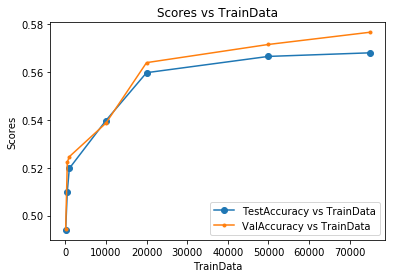

In [31]:
accuracyVisualization()

In [32]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("DT_Mrr.png")
    plt.show()

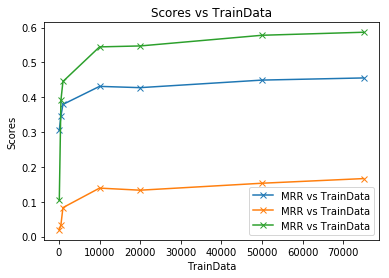

In [33]:
mrrVisualization()

In [34]:
preds_test_probs = model.predict_proba(X_test_cls)

In [35]:
qid2c,qid2indexmap = load_ranking("test")

In [36]:
mrrwrapper(qid2c,qid2indexmap,preds_test_probs)

(0.4555925444925429, 0.16666666666666666, 0.5866666666666667)

In [37]:
preds_test_probs

array([[0.58790296, 0.41209704],
       [0.69928479, 0.30071521],
       [0.76049516, 0.23950484],
       ...,
       [0.43873179, 0.56126821],
       [0.43873179, 0.56126821],
       [0.43873179, 0.56126821]])

In [9]:
mrrScore =[(0.3056746031746, 0.019333333333333334, 0.104), (0.3460654160654147, 0.034, 0.3913333333333333), (0.37953328523328433, 0.08333333333333333, 0.44533333333333336), (0.43130004810004696, 0.13933333333333334, 0.5446666666666666), (0.42764280904280855, 0.13333333333333333, 0.5473333333333333), (0.4493439153439141, 0.15333333333333332, 0.578), (0.45552587782587617, 0.16666666666666666, 0.5866666666666667)]
n_trainSamples = [100,500,1000,10000,20000,50000,75000]
mrr = []
p1 = []
p3 = []

for itm in mrrScore:
    mrr.append(itm[0])
    p1.append(itm[1])
    p3.append(itm[2])

In [10]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrr,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("DT_MrrScore.png")
    plt.show()

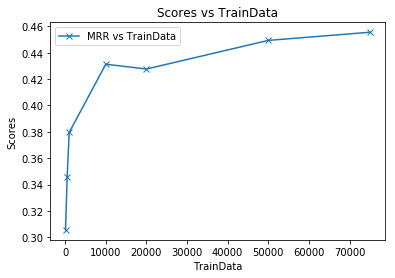

In [11]:
mrrVisualization()

In [12]:
def prVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,p1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,p3,label='Precision@3 vs TrainData',marker='.')
    plt.title("Precision Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("DT_Precision.png")
    plt.show()

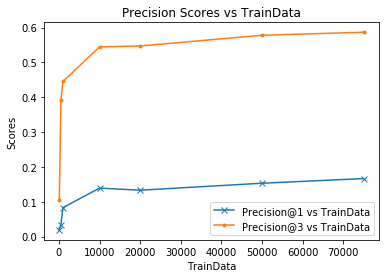

In [13]:
prVisualization()